<figure>
  <IMG SRC="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" WIDTH=25% ALIGN="right">
</figure>

<p><div> 
<br><b>Probabilistic Design</b>
<br><b>CEGM2XXX</b>
<br> <i>This course is given at the faculty of Civil Engineering and Geosciences at the Technical University of Delft</i>
<br><b>Teaching team:</b>
<br><i>- Dr. Ir. R.C.Lanzafame </i>
<br><i>- Dr. P.M. Nasarre</i>
</div>
<br>
<br><b>Notebooks created by teaching assistant:</b>
<br><i>- Siemen Algra</i>
</div>

### Case study: Component Reliability Analysis, Probabilistic part
**Floating and submerged tunnel, crossing the strait of Gibraltar**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import fsolve # for plotting the LSF

import openturns as ot
import openturns.viewer as viewer
ot.Log.Show(ot.Log.NONE)

import numpy as np
import scipy.linalg as scp
import matplotlib.pylab as plt
import time

import sympy as sp
import scipy

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

### Load FEM model and Morrisson equation in

Height of the beam: 2.38e+01 m
Width of the beam: 9.20e+00 m
Area of the beam: 3.80e+01 m2
E-modulus of the beam: 5.00e+10 Pa
Torsion constant of the beam: 5.07e+04 m4
Shear modulus of the beam: 1.92e+10 Pa
Density of the beam: 2.50e+03 kg/m3

Mass per unit length of the beam: 1.50e+05 kg/m
Bending stiffness of the beam, x-direction : 4.87e+15 N.m2
Bending stiffness of the beam, z-direction: 7.28e+14 N.m2
Axial stiffness of the beam: 1.90e+12 N
Torsional stiffness of the beam: 9.74e+14 N.m2
Moment of inertia of the beam: 1.27e+08 m2

Amount of tunnel elements: 521.0


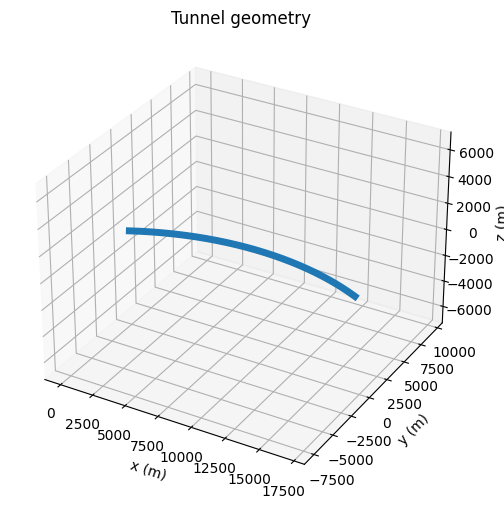

In [2]:
# Import local classes
import sys
# sys.path.append(r'../../src/')

# Obtain function that calculates the stress
import FEM
import Morrisson_forces

### 1. Determine statistical properties of Random Variables

In [3]:
# Determine the random variables using openturns
X1 = ot.Exponential(2.0309)   # Significant wave height, swell waves
X2 = ot.Exponential(2.0663)   # Significant wave height, wind sea waves
X3 = ot.Normal(2, 0.2)        # Velocity of current

In [4]:
# # Plot pdf of X1
# X1_pdf = X1.drawPDF()
# # Plot the PDF (Probability Density Function) of the distribution
# graph = X1.drawPDF()
# graph.setTitle("PDF of X1, significant wave height, swell waves")
# graph.setXTitle("x")
# graph.setYTitle("Density")
# # Show the plot using Matplotlib
# view = ot.viewer.View(graph)
# plt.show()

In [5]:
def F_morison_swell_current(significant_wave_height_swell, U_current_veloctiy):
    # General properties
    rhoW = 1025                                                 # kg/m^3
    D = np.sqrt(38/np.pi)*2                                     # diameter of cylinder
    depth = 30                                                  # depth of water

    # Swell Wave properties
    Tp = 12
    Omega = 2*np.pi/Tp
    L = 9.81*Tp**2/(2*np.pi)
    k = 2*np.pi/L
    Amplitude = significant_wave_height_swell/2                 # wave amplitude

    
    # Water velocity
    cos_func = 1 #np.cos(omega*t-k*x)
    u_swell =  Amplitude*Omega*np.exp(-k*depth)*cos_func
    
    # Intertia force
    CM = 1+((9.2/2) / (20.8/2))                                 # added mass coefficient
    F_inertia_swell =  (np.pi*rhoW*CM*D**2)/4 * (u_swell)
    
    # Drag force
    CD = 0.13 # drag coefficient
    F_drag_swell = 0.5*rhoW*CD*D*(u_swell+U_current_veloctiy)**2
    
    F_combined_swell_current = np.sqrt(F_inertia_swell**2 + F_drag_swell**2)
    
    return F_combined_swell_current


In [6]:
def F_morison_wind(significant_wave_height_windsea):
    # General properties
    rhoW = 1025                                                 # kg/m^3
    D = np.sqrt(38/np.pi)*2                                     # diameter of cylinder
    depth = 30                                                  # depth of water

    # Wind sea Wave properties
    Tp = 12
    Omega = 2*np.pi/Tp
    L = 9.81*Tp**2/(2*np.pi)
    k = 2*np.pi/L
    Amplitude = significant_wave_height_windsea/2                 # wave amplitude

    
    # Water velocity
    cos_func = 1 #np.cos(omega*t-k*x)
    u_wind =  Amplitude*Omega*np.exp(-k*depth)*cos_func
    
    # Intertia force
    CM = 1+((9.2/2) / (20.8/2))                                 # added mass coefficient
    F_inertia_wind =  (np.pi*rhoW*CM*D**2)/4 * (u_wind)
    
    # Drag force
    CD = 0.13 # drag coefficient
    F_drag_wind = 0.5*rhoW*CD*D*(u_wind)**2
    
    F_combined_wind = np.sqrt(F_inertia_wind**2 + F_drag_wind**2)
    
    return F_combined_wind

In [7]:
def total_calculation_axial_stresses(significant_wave_height_swell, significant_wave_height_windsea, U_current_velocity):
    
    # Calculate stress using FEM
    sigma_wind = FEM.calculate_stress_FEM(F_morison_wind(significant_wave_height_windsea))
    sigma_swell = FEM.calculate_stress_FEM(F_morison_swell_current(significant_wave_height_swell, U_current_velocity))
    
    # Total stress
    sigma = sigma_wind + sigma_swell 
    
    return sigma 

### 2. Determine Limit State Function

In [8]:
# Determine myLSF
def myLSF(x):
    ''' 
    Vectorized limit-state function.

    Arguments:
    x: vector. x=[X1, X2, X3]. 
    '''
    
    
    

    sigma_max = 75 # MPa, maximum allowable compression stress in special concrete
    
    # g = [sigma_max - np.max(np.abs(total_calculation_axial_stresses(x[0], x[1], x[2])))]
    g = [sigma_max - np.max(total_calculation_axial_stresses(x[0], x[1], x[2]))]
    
    return g



### 6. Run Monte Carlo Simulation and FORM analysis
*Depending on the monte carlo sample size, can take quite some time to run (hours)*

In [9]:
import Probabilistic

In [10]:
Probabilistic.run_FORM_and_MCS(X1, X2, X3, myLSF, mc_size = 100)

The FORM analysis took 173.2704827785492 seconds
FORM result, pf = 0.1845
FORM result, beta = 0.898

The design point in the u space:  [0.594602,0.672759,0.0295559]
The design point in the x space:  [0.633786,0.669843,2.00591]
The Monte Carlo simulation took 18.729708433151245 seconds
pf for MCS:  0.3


The importance factors [windsea : 0.43809, swell : 0.560828, u_current : 0.00108243]


In [12]:
Probabilistic.run_FORM_and_MCS_part2()

---------------Running part 2 of FORM and MCS-------------------
The importance factors as defined in the textbook are:  [0.661883,0.748884,0.0329002]
The sensitivity factors of the reliability index with regards to the distribution parameters are:

[lambda_marginal_0 : 0.346448, gamma_marginal_0 : -1.11016]
[lambda_marginal_1 : 0.395014, gamma_marginal_1 : -1.21852]
[mu_0_marginal_2 : -0.164008, sigma_0_marginal_2 : -0.00484739]
[R_2_1_copula : 0, R_3_1_copula : 0, R_3_2_copula : 0]
